In [19]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
from pathlib import Path

import pandas as pd
import torch

from hub.geodesic import *
from hub.metrics import *

In [21]:
data_path = Path(os.getcwd()).parent/"data"
def get_df():
    na_air_df = pd.read_csv(data_path/"na_airports.csv")
    hi_air_df = pd.read_csv(data_path/"hi_airports.csv")
    pak_air_df = pd.read_csv(data_path/"pak_airports.csv")
    bangla_air_df = pd.read_csv(data_path/"bangla_airports.csv")
    na_air_df.drop(columns=["Unnamed: 0"], inplace=True)
    hi_air_df.drop(columns=["Unnamed: 0"], inplace=True)
    pak_air_df.drop(columns=["Unnamed: 0"], inplace=True)
    bangla_air_df.drop(columns=["Unnamed: 0"], inplace=True)
    df = pd.concat([na_air_df, hi_air_df, pak_air_df, bangla_air_df], ignore_index=True)
    
    return df, na_air_df, hi_air_df, pak_air_df, bangla_air_df

df, na_air_df, hi_air_df, pak_air_df, bangla_air_df = get_df()

In [22]:
points = Points(df)

In [23]:
def fit():
    hub = torch.rand((1, 2), requires_grad=True)
    hub = hub * torch.tensor([1, 1]) + torch.tensor([48, 7]) 

    print(f"initial approximation: {hub}")

    hubs = []
    lr = 5e-3
    prev_grad = None

    for epoch in range(10000):
        loss = exp_cost(hub, points, 0.25)
        
        if epoch % 500 == 0:
            print(f"iteration: {epoch}, {loss}")

        hub.retain_grad()
        loss.backward(retain_graph=True)

        with torch.no_grad():
            grad = hub.grad / torch.sqrt(hub.grad @ hub.grad.T)
            hub -= lr * grad

            if prev_grad is not None:
                mult = prev_grad @ grad.T
                if mult < -0.5:
                    break
                
            prev_grad = grad

            hub.grad.zero_()


        hubs.append(hub.detach().numpy().copy())
        
    return hub.detach().numpy().copy(), hubs

hub, history = fit()

initial approximation: tensor([[48.9881,  7.4839]], grad_fn=<AddBackward0>)
iteration: 0, 6.749494826082821
iteration: 500, 6.482863552688932
iteration: 1000, 6.2404859275545075
iteration: 1500, 6.020889718195955
iteration: 2000, 5.822634410617936
iteration: 2500, 5.6444523470077534
iteration: 3000, 5.485163085447235
iteration: 3500, 5.343693550613839
iteration: 4000, 5.219054662287897
iteration: 4500, 5.110329976253613
iteration: 5000, 5.016650588667806
iteration: 5500, 4.937152905590639
iteration: 6000, 4.870906001345109
iteration: 6500, 4.816775463744815
iteration: 7000, 4.773169842535056
iteration: 7500, 4.737703169055907
iteration: 8000, 4.707200378248958
iteration: 8500, 4.6786865553373165
iteration: 9000, 4.65044647374852
iteration: 9500, 4.6219276212935405


In [24]:
hub

array([[ 75.53782 , -29.131544]], dtype=float32)

# Visualization 

In [25]:
na_unique = list(na_air_df.country.unique())
hi_unique = list(hi_air_df.country.unique())
pak_unique = list(pak_air_df.country.unique())
bangla_unique = list(bangla_air_df.country.unique())

#df["Continent"] = df["country"].isin(na_unique)
df.loc[df["country"].isin(na_unique), "Continent"] = "NA"
df.loc[df["country"].isin(hi_unique), "Continent"] = "HI"
df.loc[df["country"].isin(pak_unique), "Continent"] = "PAK"
df.loc[df["country"].isin(bangla_unique), "Continent"] = "BANGLA"

hub_df = pd.DataFrame([{"lat": hub[0,0], "lng": hub[0, 1], "Continent": "hub", "country": "hub"}])
hubs_df = pd.DataFrame([{"lat": hub_i[0,0], "lng": hub_i[0, 1], "Continent": "hub_", "country": "hub"} 
                       for hub_i in history[-20:]])
vis_df = pd.concat([df, hub_df, hubs_df], ignore_index=True)

In [26]:
import plotly.express as px
fig = px.scatter_geo(vis_df, lat="lat", lon="lng", color="Continent",
                     hover_name="country",
                     projection="natural earth")
fig.show()

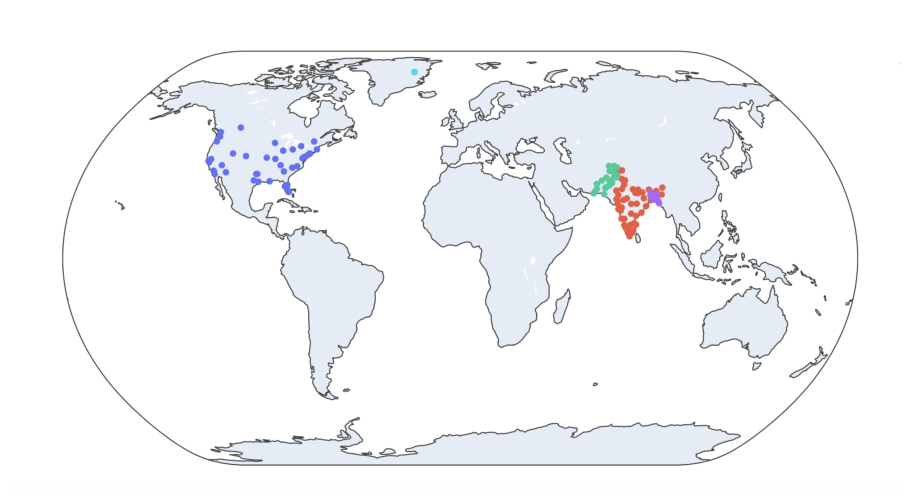

In [27]:
import matplotlib.pyplot as plt
img_path = Path(os.getcwd()).parent/"map_final.png"
img = plt.imread(img_path)
plt.figure(figsize=(16,9))
plt.imshow(img)
plt.axis("off")
plt.show()